# PW1 - Handwritten character recognition


In [112]:
# Write your name here (e.g. "Edmond Dantès") so I can grade your work
your_name = "Marc Deroo"
assert your_name

In [113]:
%matplotlib inline
import math, sys, os, torch, torchvision
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [111]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


We will be training many models. Select a number of epochs to train each model. If you are using a slow machine, or if you want to restart training often and have many development iterations, we suggest `NUM_EPOCH = 2`. If you are using a fast machine, or have a GPU available, of if you are confident that you can write accurate code first try, you will get better accuracies by increasing this constant. You could be able to afford up to `NUM_EPOCH = 10`.

In [114]:
NUM_EPOCH = 2

# Part A - Linear, MLP, and CNN


## Handwritten digit recognition dataset

We will use the MNIST database (Modified National Institute of Standards and Technology database). It contains tens of thousands of pictures of handwritten digits. This database was compiled in 1994, as part of the effort in the 1990s to standardize automation of sorting devices with human input, for instance sorting mail with handwritten postal codes at the post office. This is now often considered one of the first real successes of neural networks, and the first easy example on which performance of new such algorithms is tested.

Load the dataset (train and test splits) using `torchvision`

In [115]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

root_dir = './data/MNIST/'

transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root=root_dir, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=root_dir, train=False, download=True, transform=transform)

How many examples in each split? 

Plot the first image and label of the training set using `matplotlib`

What is the input dimension?

In [116]:
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of test examples: {len(test_dataset)}")

Number of training examples: 60000
Number of test examples: 10000


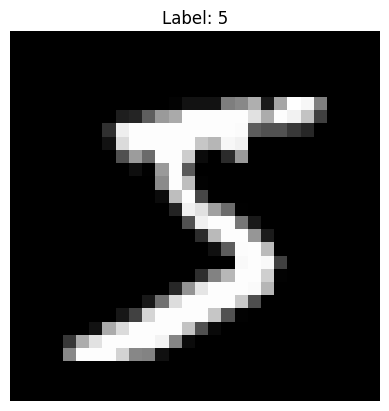

In [117]:
import matplotlib.pyplot as plt

image, label = train_dataset[0]

plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [118]:
print(f"Image shape: {image.shape}")

Image shape: torch.Size([1, 28, 28])


# A.1 - Linear features

We start with a very simple model, linear with respect to pixel values.
Use a `preprocess` function to downsample the image to 7x7 pixels, then flatten it and use a `torch.nn.Linear` model.

The torch average-pooling function is `torch.nn.functional.avg_pool2d`, check the documentation to set the arguments properly.
DO NOT use your implementation of average-pooling, it would take prohibitively long to train and you would not finish the practical.
If the training takes too long, go back to the first section and lower the `NUM_EPOCH` constant.

Again, use matplotlib to visualize an example of downsampling

In [ ]:
import torch.nn.functional as F

def preprocess(x):
    x = F.avg_pool2d(x, kernel_size=4)  
    return x.view(x.size(0), -1)        

class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(49, 10)

    def forward(self, x):
        return self.linear(x)

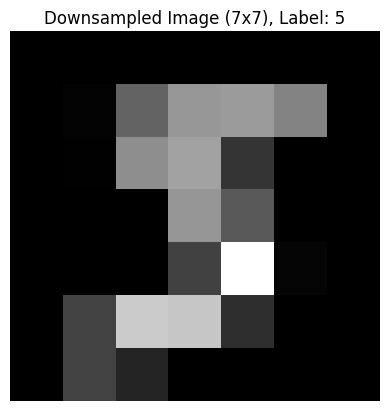

In [122]:
sample_img, sample_label = train_dataset[0]
downsampled_img = F.avg_pool2d(sample_img.unsqueeze(0), kernel_size=4).squeeze()

plt.imshow(downsampled_img, cmap='gray')
plt.title(f"Downsampled Image (7x7), Label: {sample_label}")
plt.axis('off')
plt.show()

## A.2 - Loss and optimizer
Create a cross entropy loss.

In [123]:
criterion = nn.CrossEntropyLoss()

## A.3 - Training and testing loops
Finally, create the functions `train(model, epoch, preprocess, optimizer)` and `test(model)` to train (one epoch with SGD and a learning rate of $10^{-3}$) and test your model.

In [124]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
def train(model, epoch, preprocess, optimizer):
    model.train()
    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0

    for data, target in train_loader:
        data = preprocess(data)  
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        preds = output.argmax(dim=1)
        correct += (preds == target).sum().item()
        total += target.size(0)

    train_accuracy = 100. * correct / total
    print(f"[Epoch {epoch}] Train Accuracy: {train_accuracy:.2f}%")
    return optimizer, train_accuracy


def test(model, preprocess):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data = preprocess(data)  
            output = model(data)
            preds = output.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)

    accuracy = 100. * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

You should get at least 85\% test accuracy even with only 2 epochs. We will be aiming for around 95\% test accuracy and above.

In [126]:
model = LinearModel()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)

for epoch in range(1, NUM_EPOCH + 1):
    optimizer, _ = train(model, epoch, preprocess, optimizer)
    test(model, preprocess)

[Epoch 1] Train Accuracy: 82.49%
Test Accuracy: 87.06%
[Epoch 2] Train Accuracy: 86.30%
Test Accuracy: 87.68%


## A.4 - Multi-layer perceptron (MLP)

Create a class MLP that creates an MLP of given width and depth, and use it to create a 3-layer MLP of width $100$. We will assume that `width > 0` and `depth > 0`.

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim=49, width=100, depth=3, output_dim=10):
        super().__init__()
        layers = []

        layers.append(nn.Linear(input_dim, width))
        layers.append(nn.ReLU())

        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(width, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [128]:
model = MLP(input_dim=49, width=100, depth=3)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)

for epoch in range(1, NUM_EPOCH + 1):
    optimizer, _ = train(model, epoch, preprocess, optimizer)
    test(model, preprocess)

[Epoch 1] Train Accuracy: 82.92%
Test Accuracy: 93.17%
[Epoch 2] Train Accuracy: 92.96%
Test Accuracy: 92.97%


# A.5 - Deep convolutional model

Write a convolutional model, with learned features.
Use two layers, one convolutional with 8 filters of size 3x3, then take a relu and max-pool with kernel size 2, and finally flatten and add a Linear layer. You can use the identity as pre-processing function.


Here is a little animation to remind you of the sliding window principle of convolutions.

![conv](https://github.com//vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif)

In [ ]:
class ConvModel(torch.nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)       
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(8 * 13 * 13, 10)

    def forward(self,x):
        x = self.conv(x)           
        x = F.relu(x)              
        x = self.pool(x)           
        x = x.view(x.size(0), -1)  
        x = self.fc(x)             
        return x

In [132]:
model = ConvModel()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
NUM_EPOCH = 10

for epoch in range(1, NUM_EPOCH + 1):
    optimizer, _ = train(model, epoch, lambda x: x, optimizer) 
    test(model, lambda x: x)

[Epoch 1] Train Accuracy: 89.25%
Test Accuracy: 93.34%
[Epoch 2] Train Accuracy: 94.34%
Test Accuracy: 96.07%
[Epoch 3] Train Accuracy: 96.28%
Test Accuracy: 96.73%
[Epoch 4] Train Accuracy: 97.06%
Test Accuracy: 97.05%
[Epoch 5] Train Accuracy: 97.58%
Test Accuracy: 97.50%
[Epoch 6] Train Accuracy: 97.90%
Test Accuracy: 97.93%
[Epoch 7] Train Accuracy: 98.17%
Test Accuracy: 97.94%
[Epoch 8] Train Accuracy: 98.33%
Test Accuracy: 98.05%
[Epoch 9] Train Accuracy: 98.46%
Test Accuracy: 98.21%
[Epoch 10] Train Accuracy: 98.58%
Test Accuracy: 98.17%


You should be able to get around 97\% to 98\% accuracy with this model. Try increasing the NUM_EPOCH constant and watch what happens to test accuracy and train accuracy as training progresses further.

Write a deeper convolutional model, with one convolutional layer as previously, but three linear layers with relu activations after that.
Use `h = 100` hidden neurons. How does the test accuracy compare with the previous two-layer network ?

**Réponse :** En ajoutant des couches linéaires supplémentaires avec h=100, on observe une légère amélioration de la précision sur le jeu de test, et une grande amélioration sur les données d’entraînement. Ce modèle semble mieux, mais il faut surveiller l’overfitting.

In [134]:
class ConvDeepModel(torch.nn.Module):
    def __init__(self, h=100):
        super(ConvDeepModel, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)

        flatten_dim = 8 * 13 * 13

        self.fc1 = nn.Linear(flatten_dim, h)
        self.fc2 = nn.Linear(h, h)
        self.fc3 = nn.Linear(h, 10)

    def forward(self,x):
        x = self.conv(x)           
        x = F.relu(x)
        x = self.pool(x)           
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))    
        x = F.relu(self.fc2(x))    
        x = self.fc3(x)            
        return x

In [135]:
model = ConvDeepModel(h=100)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
NUM_EPOCH = 10

for epoch in range(1, NUM_EPOCH + 1):
    optimizer, _ = train(model, epoch, lambda x: x, optimizer)
    test(model, lambda x: x)

[Epoch 1] Train Accuracy: 89.84%
Test Accuracy: 96.33%
[Epoch 2] Train Accuracy: 96.92%
Test Accuracy: 97.38%
[Epoch 3] Train Accuracy: 97.88%
Test Accuracy: 97.79%
[Epoch 4] Train Accuracy: 98.43%
Test Accuracy: 98.21%
[Epoch 5] Train Accuracy: 98.69%
Test Accuracy: 98.36%
[Epoch 6] Train Accuracy: 98.93%
Test Accuracy: 98.30%
[Epoch 7] Train Accuracy: 99.11%
Test Accuracy: 98.60%
[Epoch 8] Train Accuracy: 99.28%
Test Accuracy: 98.27%
[Epoch 9] Train Accuracy: 99.42%
Test Accuracy: 98.44%
[Epoch 10] Train Accuracy: 99.55%
Test Accuracy: 98.45%


## A.6 Visualisations of convolutions

After training your model, let's see what features it has learned!

Plot an image from the test set then plot all 8 feature maps extracted by the convolutional layer

In [ ]:
def visualize_feature_maps(model, dataset):
    model.eval()

    image, label = dataset[0]
    image = image.unsqueeze(0)  

    with torch.no_grad():
        x = model.conv(image)
        x = F.relu(x)  
        feature_maps = x.squeeze(0)  

    plt.figure(figsize=(3, 3))
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Original Image - Label: {label}")
    plt.axis('off')
    plt.show()

    fig, axs = plt.subplots(2, 4, figsize=(10, 5))
    for i in range(8):
        ax = axs[i // 4, i % 4]
        ax.imshow(feature_maps[i], cmap='viridis')
        ax.axis('off')
        ax.set_title(f"Feature Map {i+1}")
    plt.tight_layout()
    plt.show()

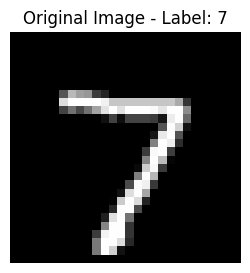

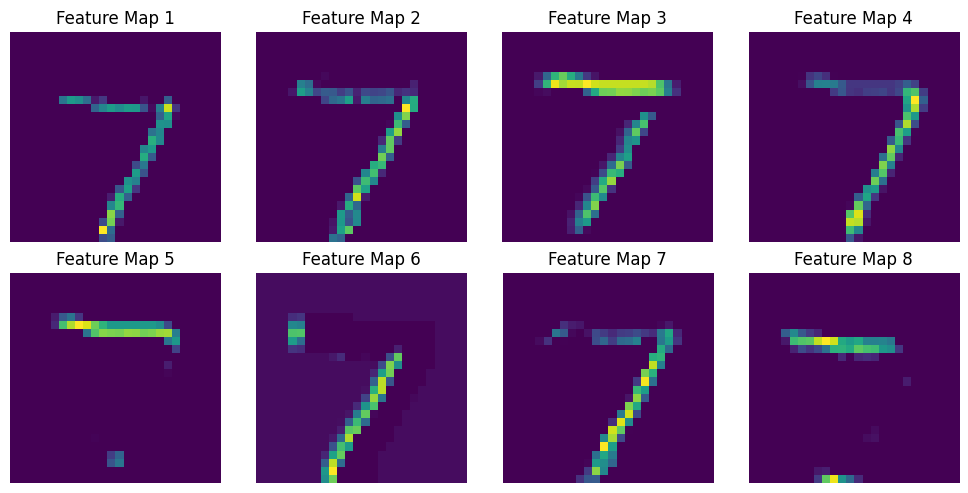

In [138]:
visualize_feature_maps(model, test_dataset)

# Part B - Residual models

## B.1 - Residual blocks

Write a residual block with two linear layers to learn a function $\mathbb{R}^d \to \mathbb{R}^d$ with $h < d$ hidden neurons.
Write a convolutional residual block with the same idea. What hyperparameter acts as the number of hidden neurons in convolutional blocks ?

**Réponse :** C'est l'hyperparamètre h qui est le nombre de canaux de sortie.

In [ ]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, d, h):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(d, h)
        self.fc2 = nn.Linear(h, d)

    def forward(self,x):
        residual = x 
        out = F.relu(self.fc1(x))
        out = self.fc2(out)
        return out + residual 

In [ ]:
class ConvolutionalResidualBlock(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(ConvolutionalResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x  
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        return out + residual

In [141]:
block = ConvolutionalResidualBlock(in_channels=8, hidden_channels=4)

x = torch.randn(32, 8, 28, 28)
out = block(x)
print(out.shape)

torch.Size([32, 8, 28, 28])


## B.2 - Stacking residual blocks

Use a single convolution layer, followed by a relu and max-pool, then an arbitrary number of residual blocks as defined above, and finish with a linear layer. Can you match the accuracy of the two-layer network ? Can you exceed it ? What happens when you increase the number of layers ? Look at the details of the ResNet architecture on the lecture's slides to get an idea of how to increase the number of hidden neurons and the number of layers. One of the strengths of ResNets was there relatively low number of parameters compared
to a multi-layer architecture like that of the previous section, does this show in your experiments ?


- Le modèle avec blocs résiduels atteint 98.73% de précision dès la 3ᵉ époque, ce qui dépasse la précision maximale obtenue avec le modèle à deux couches convolutionnelles + linéaire.

- Le modèle résiduel atteint un maximum de 99.11% de précision, ce qui surpasse tous les modèles précédents, y compris le modèle plus profond avec 3 couches linéaires (`h = 100`).

---

- En augmentant le nombre de blocs résiduels :
    - La capacité d'apprentissage augmente.
    - La précision sur le jeu de test reste stable et élevée.
    - Les blocs résiduels permettent d'entraîner des réseaux plus profonds sans dégradation des performances.

---

In [ ]:
class ResidualModel(torch.nn.Module):
    def __init__(self, l, h, k=3, out=8):
        super(ResidualModel, self).__init__()

        self.conv = nn.Conv2d(1, out, kernel_size=k, padding=k // 2)
        self.pool = nn.MaxPool2d(2)

        self.res_blocks = nn.Sequential(
            *[ConvolutionalResidualBlock(out, h) for _ in range(l)]
        )

        self.flatten_dim = out * 14 * 14
        self.fc = nn.Linear(self.flatten_dim, 10)

    def forward(self,x):
        x = self.conv(x)           
        x = F.relu(x)
        x = self.pool(x)           
        x = self.res_blocks(x)     
        x = x.view(x.size(0), -1)  
        x = self.fc(x)
        return x

In [143]:
model = ResidualModel(l=4, h=16, out=8)  
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
NUM_EPOCH = 10

for epoch in range(1, NUM_EPOCH + 1):
    optimizer, _ = train(model, epoch, lambda x: x, optimizer)
    test(model, lambda x: x)

[Epoch 1] Train Accuracy: 93.56%
Test Accuracy: 98.14%
[Epoch 2] Train Accuracy: 98.15%
Test Accuracy: 98.58%
[Epoch 3] Train Accuracy: 98.55%
Test Accuracy: 98.73%
[Epoch 4] Train Accuracy: 98.74%
Test Accuracy: 98.39%
[Epoch 5] Train Accuracy: 98.97%
Test Accuracy: 98.70%
[Epoch 6] Train Accuracy: 99.03%
Test Accuracy: 98.95%
[Epoch 7] Train Accuracy: 99.13%
Test Accuracy: 99.11%
[Epoch 8] Train Accuracy: 99.22%
Test Accuracy: 98.99%
[Epoch 9] Train Accuracy: 99.33%
Test Accuracy: 98.92%
[Epoch 10] Train Accuracy: 99.35%
Test Accuracy: 99.00%


In [176]:
total_params_ResMod = sum(p.numel() for p in ResidualModel(l=4, h=16, out=8).parameters())
total_params_MultiLay = sum(p.numel() for p in ConvDeepModel(h=100).parameters())

print(f"Total number of parameters of MultiLayer: {total_params_MultiLay}")
print(f"Total number of parameters of ResidualModel: {total_params_ResMod}")

Total number of parameters of MultiLayer: 146490
Total number of parameters of ResidualModel: 25082


**Réponse :** On a bien beaucoup moins de paramètres !

# Part C - Reimplementing loss functions

## C.0 - Combining losses
First, we recall that, for a batch of score vectors $s\in\mathbb{R}^{n\times C}$ and true labels $y\in[1,C]^n$, **cross entropy** is defined as
$$CE(s, y) = -\frac{1}{n}\sum_{i=1}^n \log\left( \mbox{softmax}(s_i)_{y_i} \right)$$

where $\mbox{softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$ is the probability associated to class $i\in[1,C]$ for a score vector $x\in\mathbb{R}^C$.

Let's try to compute cross-entropy in three different ways (see the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)):
1. Using `nn.CrossEntropyLoss()`.
2. Using `nn.NLLLoss()` and `nn.LogSoftmax()`.
3. Using `nn.NLLLoss()` and `nn.Softmax()`.

Check that the output is the same for all three methods on Gaussian random scores `torch.randn(n_batch, n_classes)` and random labels `torch.randint(0, n_classes, [n_batch])`, where `n_batch=4` and `n_classes=10`. Note that the scores are real valued vectors while the labels are integers corresponding to the true class.

In [158]:
n_batch = 4
n_classes = 10

torch.manual_seed(0)
scores = torch.randn(n_batch, n_classes)  
labels = torch.randint(0, n_classes, (n_batch,))

# Méthode 1: CrossEntropyLoss
criterion1 = nn.CrossEntropyLoss()
loss1 = criterion1(scores, labels)

# Méthode 2: NLLLoss + LogSoftmax
criterion2 = nn.NLLLoss()
log_probs = F.log_softmax(scores, dim=1)
loss2 = criterion2(log_probs, labels)

# Méthode 3 
soft_probs = F.softmax(scores, dim=1)
loss3 = criterion2(soft_probs.log(), labels)  

print("Loss with CrossEntropyLoss:          ", loss1.item())
print("Loss with NLLLoss + LogSoftmax:      ", loss2.item())
print("Loss with NLLLoss + Softmax + log(): ", loss3.item())

Loss with CrossEntropyLoss:           2.997688055038452
Loss with NLLLoss + LogSoftmax:       2.997688055038452
Loss with NLLLoss + Softmax + log():  2.997688055038452


On obtient bien les même valeurs.

## C.1 - Re-implementation
Now re-implement cross-entropy using base functions (`torch.log`, `torch.exp`, `torch.sum`, etc...). Verify that your function returns the same value as Pytorch's implementation.

In [150]:
def ce(logits, targets):
    exp_logits = torch.exp(logits)
    probs = exp_logits / torch.sum(exp_logits, dim=1, keepdim=True)

    target_probs = probs[torch.arange(len(targets)), targets]
    log_likelihood = -torch.log(target_probs)

    return log_likelihood.mean()

In [156]:
# Exemple de test
n_batch = 4
n_classes = 10
logits = torch.randn(n_batch, n_classes, requires_grad=True)
targets = torch.randint(0, n_classes, (n_batch,))

# Notre version
manual_loss = ce(logits, targets)

# Version officielle PyTorch
official_loss = nn.CrossEntropyLoss()(logits, targets)

print(f"Manual CE : {manual_loss.item():.6f}")
print(f"Official  : {official_loss.item():.6f}")

Manual CE : 2.884872
Official  : 2.884872


On obtient bien les même valeurs.

## C.2 - Stability analysis
Softmax probabilities can be relatively unstable due to their use of exponentials. Pytorch implementations thus usually use log probas or logits to avoid overflows or floating point errors. Test all methods (including your own) on Gaussian random scores of standard deviation equal to $100$. Which methods are stable? Why? Is it an issue in practice?


- `nn.CrossEntropyLoss()` et `log_softmax + NLLLoss` sont stables. Elles utilisent les logits et appliquent une fonction log-softmax pour éviter les problèmes d'overflow ou de sous-flux numériques. Cela permet de traiter des logits extrêmes sans erreurs.


- `softmax + log + NLLLoss` est instable. La fonction softmax appliquée aux logits peut produire des valeurs exponentielles très grandes ou très petites, ce qui peut conduire à des résultats infiniment grands ou petits lors de l'application de log.


- Cela peut poser problème. Les grandes valeurs de logits peuvent entraîner des erreurs numériques (NaN ou inf), ce qui empêche le modèle d'apprendre correctement ou de donner des résultats valides.


---

In [174]:
n_batch = 4
n_classes = 10
std = 100

logits = torch.randn(n_batch, n_classes) * std
targets = torch.randint(0, n_classes, (n_batch,))

print("Max logit:", logits.max().item())
print("Min logit:", logits.min().item())

# 1. CrossEntropyLoss (stable)
try:
    loss1 = nn.CrossEntropyLoss()(logits, targets)
    print(f"1. nn.CrossEntropyLoss       : {loss1.item():.6f}")
except Exception as e:
    print("1. nn.CrossEntropyLoss       : ERROR -", e)

# 2. log_softmax + NLLLoss (stable)
try:
    log_probs = F.log_softmax(logits, dim=1)
    loss2 = nn.NLLLoss()(log_probs, targets)
    print(f"2. log_softmax + NLLLoss     : {loss2.item():.6f}")
except Exception as e:
    print("2. log_softmax + NLLLoss     : ERROR -", e)

# 3. softmax + log + NLLLoss (instable)
try:
    probs = F.softmax(logits, dim=1)
    log_probs_manual = torch.log(probs + 1e-9) 
    loss3 = nn.NLLLoss()(log_probs_manual, targets)
    print(f"3. softmax + log + NLLLoss   : {loss3.item():.6f}")
except Exception as e:
    print("3. softmax + log + NLLLoss   : ERROR -", e)

# 4. Notre version manuelle avec log-sum-exp
def ce(logits, targets):
    log_sum_exp = torch.log(torch.sum(torch.exp(logits), dim=1))  
    batch_indices = torch.arange(logits.size(0))  
    correct_class_scores = logits[batch_indices, targets] 
    loss = log_sum_exp - correct_class_scores 
    return loss.mean()

try:
    loss4 = ce(logits, targets)
    print(f"4. ce() manually implemented : {loss4.item():.6f}")
except Exception as e:
    print("4. ce() manually implemented : ERROR -", e)

Max logit: 305.669677734375
Min logit: -248.78030395507812
1. nn.CrossEntropyLoss       : 190.090240
2. log_softmax + NLLLoss     : 190.090240
3. softmax + log + NLLLoss   : 20.723267
4. ce() manually implemented : inf


Re-implement a stable version of cross-entropy.

In [159]:
def stable_ce(logits, targets):

    logits_stable = logits - torch.max(logits, dim=1, keepdim=True)[0]

    log_probs = logits_stable - torch.log(torch.sum(torch.exp(logits_stable), dim=1, keepdim=True))
    nll = -log_probs[torch.arange(len(targets)), targets]

    return nll.mean()

In [171]:
logits = torch.randn(4, 10) * 100  # logits extrêmes
targets = torch.randint(0, 10, (4,))

# Doit être proche de PyTorch officiel
print("Stable CE     :", stable_ce(logits, targets).item())
print("Official CE   :", nn.CrossEntropyLoss()(logits, targets).item())

Stable CE     : 150.87271118164062
Official CE   : 150.87271118164062
